# Convolutional Neural Networks for Hyperspectral Image Classification

Goals of the lecture:
1. Strengthen understanding of pixel-based classification for hyperspectral images
2. Simple 1D/2D-CNN architectures in PyTorch
3. Set-Up a training procedure with PyTorch
4. Train and evaluate neural networks

The content of this notebook is based on the DeepHyperX repository. The complete code is available at: [https://git.tu-berlin.de/rsim/deephyperx2.0](https://git.tu-berlin.de/rsim/deephyperx2.0). The linked repository is an enhancend version of the original repository, many functions were refurbished and re-formated.

The Original Hyperspectral dataset is publicly available at [http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes). This notebook downloads the Pavia dataset automatically for you to "./data". Alternatively, you can download it as a zip file directly from the TUB-cloud: https://tubcloud.tu-berlin.de/s/j9KR2gR35wCGP87/download/PaviaU.zip)

## Import Packages

In [1]:
import sys

sys.path.insert(0, "/tmp/DeepHyperX")

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spectral

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from datasets import get_dataset, HyperX
from utils import get_device

## Download Dataset from Original Repo 

This notebook downloads "PaviaU" image, and corresponding ground reference map (class labels assigned per pixel). 

* "PaviaU" image includes 103 bands.

* Land cover map includes 9 classes 'Asphalt', 'Meadows', 'Gravel', 'Trees', \
'Painted metal sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows'.

**Note** that in the classification map some areas are not labeled ('Undefined'), so we exclude them. 

In [3]:
# Load the dataset
hyper_datacube, gt, labels, ignored_labels, _, _ = get_dataset("PaviaU", target_folder="./data/")
num_bands = hyper_datacube.shape[-1]
num_classes = len(labels) - len(ignored_labels)

params = {}
params["device"] = get_device(0)  # -1 for CPU, otherwise GPU No.
params["num_bands"] = num_bands
params["num_classes"] = num_classes
params["ignored_labels"] = ignored_labels

/!\ CUDA was requested but is not available! Computation will go on CPU. /!\


In [4]:
hyper_datacube.shape

(610, 340, 103)

In [5]:
gt.shape

(610, 340)

# Visualize Data

A help-function to ease the plotting of the reference map.

In [6]:
# create handles for legend
cmap = matplotlib.cm.get_cmap("tab10")
handles = [matplotlib.patches.Patch(color=cmap(i), label=labels[i]) for i in range(10)]

In [7]:
# adjusts colormap according to classes present in label map
def adjust_cmap(data, cmap_name):
    cmap = matplotlib.cm.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, cmap.N))
    adj_colors = colors[: np.max(data) + 1]
    return matplotlib.colors.ListedColormap(adj_colors)

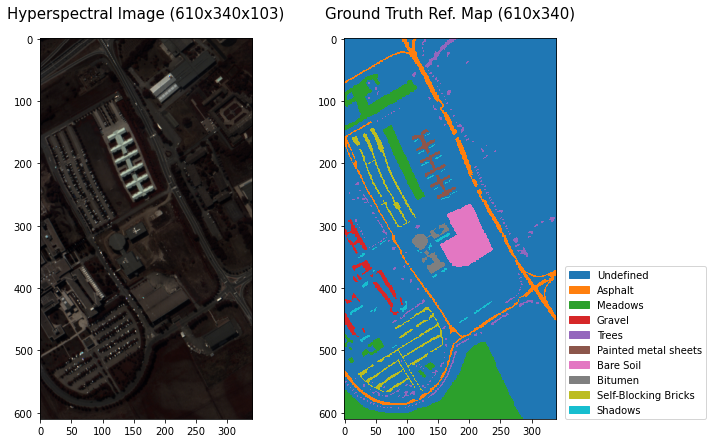

In [8]:
hypercube_rgb = spectral.get_rgb(hyper_datacube, bands=(29, 19, 9))

fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title(
    "Hyperspectral Image ({}x{}x{})".format(*hyper_datacube.shape), fontsize=15, pad=20
)
axes[0].imshow(hypercube_rgb)
axes[1].set_title("Ground Truth Ref. Map ({}x{})".format(*gt.shape), fontsize=15, pad=20)
axes[1].imshow(gt, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

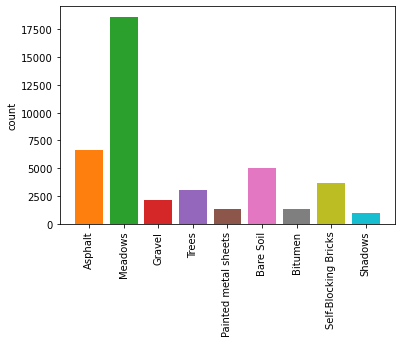

In [9]:
classes, counts = np.unique(gt, return_counts=True)
plt.bar(
    classes[1:], counts[1:], tick_label=labels[1:], color=adjust_cmap(gt, "tab10")(np.arange(1, 10))
)
plt.xticks(rotation=90)
plt.ylabel("count")
plt.show()

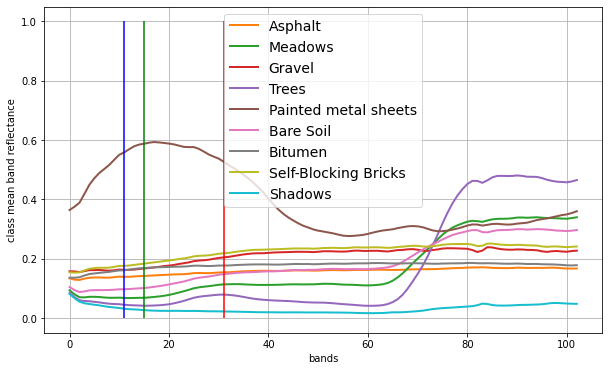

In [10]:
plt.figure(figsize=(10, 6))

for cl in range(1, 10):
    indices = np.nonzero(gt == cl)
    spectral_sig = hyper_datacube[indices].mean(axis=0)
    plt.plot(spectral_sig, label=labels[cl], linewidth=2, color=adjust_cmap(gt, "tab10")(cl))

plt.legend(fontsize=14)
plt.vlines(31, 0, 1, colors="r")
plt.vlines(15, 0, 1, colors="g")
plt.vlines(11, 0, 1, colors="b")
plt.xlabel("bands")
plt.ylabel("class mean band reflectance")
plt.grid()

## Creating Train, Validation and Test sets

We need to create three sets namley for train, validation and test purposes.

In this pixel-based classification course each set (test/val/train) includes a certain number of samples (pixels). When using 2D or 3D convolutions each sample represents a pixel with its surroundings area (patch), and corresponding assigned class label. When using 1D convolutions each sample is just represented by its 103-band pixel.

For example for "CNN1D" each sample has 1x1x103 dimension (1x1 patch size and 103 spectral bands) and one label (between 0-9). For "CNN2D" each sample has 7x7x103 dimension (7x7 patch size and 103 spectral bands).

In [11]:
def sample_gt(gt, train_percentage):
    """
    Extract a fixed percentage of samples from an array of labels.

    Parameter
    ---------
    gt                : a 2D array of int labels
    train_percentage  : [0, 1] float

    Return
    ------
    train_gt, test_gt : 2D arrays of int labels

    """
    train_gt = gt.copy()
    test_gt = gt.copy()
    for c in np.unique(gt):
        mask = gt == c
        for x in range(gt.shape[0]):
            first_half_count = np.count_nonzero(mask[:x, :])
            if first_half_count / np.count_nonzero(mask) > train_percentage:
                break

        train_mask = mask.copy()
        train_mask[:x, :] = 0
        train_gt[train_mask] = 0

        test_mask = mask.copy()
        test_mask[x:, :] = 0
        test_gt[test_mask] = 0

    return train_gt, test_gt

In [12]:
# 1st split: train/val - test
train_val_gt, test_gt = sample_gt(gt, 0.5)

n_trainval = np.count_nonzero(train_val_gt)
n_test = np.count_nonzero(test_gt)
n_total = np.count_nonzero(gt)

print("Train-Val: {} samples selected (over {})".format(n_trainval, n_total))
print("Test:      {} samples selected (over {})".format(n_test, n_total))

Train-Val: 21478 samples selected (over 42776)
Test:      21298 samples selected (over 42776)


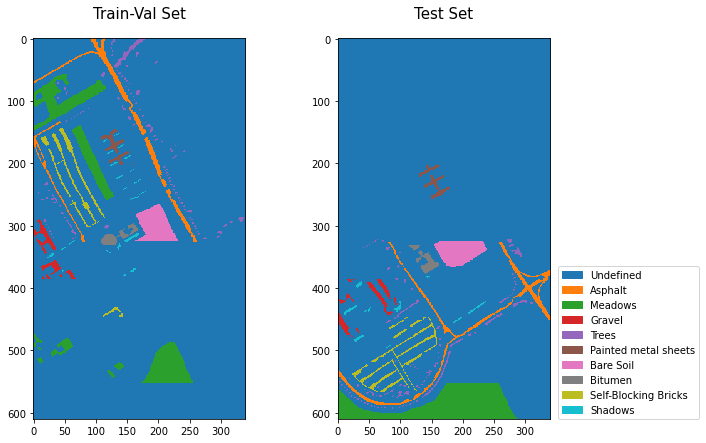

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("Train-Val Set", fontsize=15, pad=20)
axes[0].imshow(train_val_gt, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].set_title("Test Set", fontsize=15, pad=20)
axes[1].imshow(test_gt, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [14]:
# 2nd split: train - val split
train_gt, val_gt = sample_gt(train_val_gt, 0.8)

n_train = np.count_nonzero(train_gt)
n_val = np.count_nonzero(val_gt)

print("Train: {} samples selected (over {})".format(n_train, n_trainval))
print("Val:   {} samples selected (over {})".format(n_val, n_trainval))

Train: 17297 samples selected (over 21478)
Val:   4181 samples selected (over 21478)


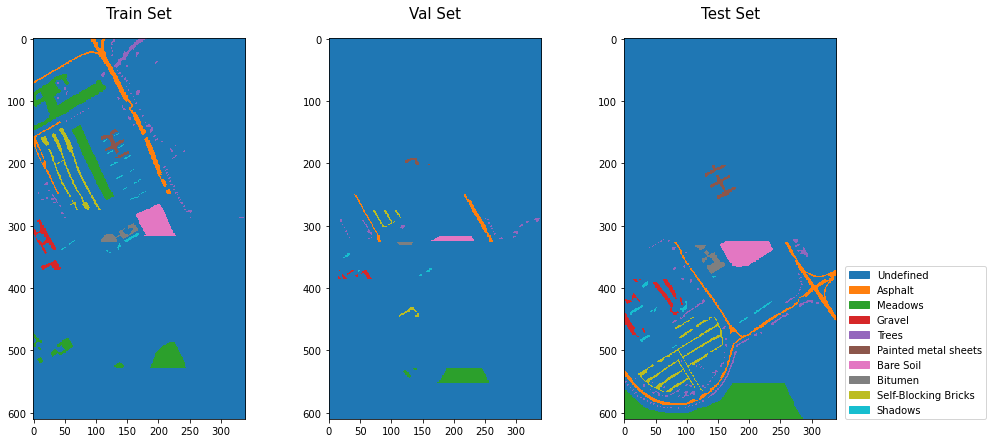

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].set_title("Train Set", fontsize=15, pad=20)
axes[0].imshow(train_gt, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].set_title("Val Set", fontsize=15, pad=20)
axes[1].imshow(val_gt, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[2].set_title("Test Set", fontsize=15, pad=20)
axes[2].imshow(test_gt, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[2].legend(handles=handles, loc=(1.04, 0))

# Define CNN Architectures

You can build and add your own architecture. In general, bulding a Neural network in PyTorch includes 3 main steps:
* Extend the nn.Module base class (e.g., class name_you_want(nn.Module))
* Define layers as class attributes
* Implement the forward() method

for more info check Pytorch documentation:

[https://pytorch.org/docs/master/nn.html#](https://pytorch.org/docs/master/nn.html#)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader
from torchinfo import summary

In [17]:
class CNN1D(nn.Module):
    def __init__(self, width, num_classes, num_filter=10):
        super(CNN1D, self).__init__()
        self.width = width

        # 10 filter with kernel of size 12 x 1
        self.conv1 = nn.Conv1d(1, num_filter, kernel_size=(12,))
        self.pool1 = nn.MaxPool1d((3,))
        self.conv2 = nn.Conv1d(num_filter, num_filter, kernel_size=(12,))
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes)
        self.apply(self.weight_init)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
            init.kaiming_normal_(m.weight.data)
            init.zeros_(m.bias)

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, self.width)
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
        return x.numel()  # multiply shape


class CNN2D(nn.Module):
    def __init__(self, input_size, num_classes, num_filter=2, patch_size=7):
        super(CNN2D, self).__init__()
        self.input_size = input_size
        self.num_channels = input_size[0]
        self.num_filter = num_filter
        self.patch_size = patch_size

        self.conv1 = nn.Conv2d(self.num_channels, num_filter, kernel_size=(3, 3), padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(num_filter, 2 * num_filter, kernel_size=(3, 3), padding=0)
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes)
        self.apply(self.weight_init)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, *self.input_size))
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
        return x.numel()  # multiply shape

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight.data)
            init.zeros_(m.bias)

Why good initalization matters: https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html#Situation

# Define Training Hyperparameter

In [18]:
cnn1d = CNN1D(num_bands, num_classes)
cnn1d = cnn1d.to(params["device"])

In [19]:
summary(cnn1d, input_size=(1, 1, 103), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNN1D                                    --                        --                        --
├─Conv1d: 1-1                            [1, 1, 103]               [1, 10, 92]               130
├─MaxPool1d: 1-2                         [1, 10, 92]               [1, 10, 30]               --
├─Conv1d: 1-3                            [1, 10, 30]               [1, 10, 19]               1,210
├─Linear: 1-4                            [1, 190]                  [1, 9]                    1,719
Total params: 3,059
Trainable params: 3,059
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

In [20]:
# fmt: off
params["patch_size"]     = 1      # 1 for 1D-CNN, 7 for 2D/3D-CNN
params["batch_size"]     = 100
params["learning_rate"]  = 0.01
params["epochs"]         = 10
# fmt: on

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    cnn1d.parameters(),
    lr=params["learning_rate"],
    momentum=0.9,
    weight_decay=0.00005,
    nesterov=True,
)

# Set-Up Data-Loader

In [22]:
train_dataset = HyperX(hyper_datacube, train_gt, **params)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)

val_dataset = HyperX(hyper_datacube, val_gt, **params)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"])

test_dataset = HyperX(hyper_datacube, test_gt, **params)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"])

KeyError: 'dataset'

# Train the Model

In [ ]:
def train(
    model,
    optimizer,
    criterion,
    train_loader,
    epochs,
    device,
    scheduler=None,
    val_loader=None,
):
    """
    Training loop to optimize a network for several epochs and a specified loss.

    Args:
    -----
    model               : a PyTorch model
    optimizer           : a PyTorch optimizer
    criterion           : a PyTorch-compatible loss function, e.g. nn.CrossEntropyLoss
    train_loader        : a PyTorch trainset loader
    epochs              : int specifying the number of training epochs
    device              : torch device to use (defaults to CPU)
    scheduler (opt.)    : PyTorch scheduler
    val_loader (opt.)   : validation dataset
    """
    model.to(device)
    losses, accuracies = [0, 0], [0, 0]

    for epoch in tqdm(range(1, epochs + 1), desc="Training the network"):
        model.train()  # set model to training mode

        # Data-Loading Loop
        with tqdm(train_loader, unit=" batch") as tepoch:
            for idx, (batch, targets) in enumerate(tepoch):
                tepoch.set_description("Epoch {}".format(epoch))

                # put loaded data on GPU
                batch, targets = batch.to(device), targets.to(device)

                # zero accumulated gradients from previous batch
                optimizer.zero_grad()

                # infer predictions for batch
                output = model(batch)
                predictions = output.argmax(dim=1)

                # compute loss from predictions, CELoss automatically applies F.log_softmax
                loss = criterion(output, targets)

                # accumulate gradients for all parameter according to batch errors
                loss.backward()

                # update paramters according to accumulated gradients
                optimizer.step()

                correct = (predictions == targets).sum().item()
                accuracy = correct / train_loader.batch_size

                losses.append(loss.item())
                accuracies.append(accuracy)

                tepoch.set_postfix(loss=np.mean(losses[-50:]), accuracy=np.mean(accuracies[-50:]))

        if val_loader is not None:
            val_losses, val_accuracies = [], []

            for batch, targets in val_loader:

                # put loaded data on GPU
                batch = batch.to(device)
                targets = targets.to(device)

                output = model(batch)
                loss = criterion(output, targets)
                predictions = output.argmax(dim=1)

                correct = (predictions == targets).sum().item()
                accuracy = correct / train_loader.batch_size
                val_losses.append(loss.item())
                val_accuracies.append(accuracy)

            print(
                "Val-Loss: {:.2f}. Val-Acc: {:.2f}".format(
                    np.mean(val_losses), np.mean(val_accuracies)
                )
            )

In [ ]:
def test(model, test_loader, class_labels):
    predictions = []
    targets = []

    for idx, (batch, target) in enumerate(tqdm(test_loader, desc="Test: ")):
        # put loaded data on GPU
        batch = batch.to(params["device"])
        target = target.to(params["device"])

        output = model(batch)
        predicted = output.argmax(dim=1)

        predictions += predicted.tolist()
        targets += target.tolist()

    results = {}

    if class_labels is None:
        class_labels = range(len(np.unique(targets)))

    cm = confusion_matrix(targets, predictions)

    results["cm"] = cm
    results["overall_acc"] = accuracy_score(targets, predictions)
    results["report"] = classification_report(
        targets,
        predictions,
        target_names=class_labels,
        zero_division=0,
        digits=4,
        output_dict=True,
    )

    return results

In [ ]:
train(
    model=cnn1d,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=params["epochs"],
    device=params["device"],
    scheduler=None,
    val_loader=val_loader,
)

In [ ]:
from infer import infer_image

In [ ]:
prediction = infer_image(cnn1d, hyper_datacube, gt, ignored_labels, params)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("GT Map", fontsize=15, pad=20)
axes[0].imshow(gt, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].set_title("Predictions", fontsize=15, pad=20)
axes[1].imshow(prediction, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [ ]:
results = test(cnn1d, test_loader, class_labels=labels[1:])

In [ ]:
df = pd.DataFrame(results["report"]).round(decimals=2).T
df[["support"]] = df[["support"]].astype(int)
df

In [ ]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=labels[1:],
    yticklabels=labels[1:],
    annot=True,
)
ax.set(xlabel="Model Prediction", ylabel="Grount Truth")

## In-course practice I

Select the model `CNN2D` for training and instantiatae it with 18 filters. This model is a deep network with 2D convolution layer which requires 7x7x103 patches. 

What you need to do:

- Change the patch size
- Intantiate the new model and re-intantiate the criterion, optimizer and data loaders
- Train and evaluate the model

In [ ]:
# fmt: off
params["patch_size"]     = 7      # 1 for 1D-CNN, 7 for 2D/3D-CNN
params["batch_size"]     = 100
params["learning_rate"]  = 0.01
params["epochs"]         = 20
# fmt: on

In [ ]:
cnn2d = CNN2D((103, 7, 7), num_classes, num_filter=18)
cnn2d = cnn2d.to(params["device"])

In [ ]:
summary(cnn2d, input_size=(100, 103, 7, 7), col_names=["input_size", "output_size", "num_params"])

In [ ]:
cnn2d = cnn2d.to(params["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    cnn2d.parameters(),
    lr=params["learning_rate"],
    momentum=0.9,
    weight_decay=0.00005,
    nesterov=True,
)

In [ ]:
train_dataset = HyperX(hyper_datacube, train_gt, **params)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)

val_dataset = HyperX(hyper_datacube, val_gt, **params)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"])

test_dataset = HyperX(hyper_datacube, val_gt, **params)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"])

In [ ]:
train(
    model=cnn2d,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=params["epochs"],
    device=params["device"],
    scheduler=None,
    val_loader=None,
)

In [ ]:
prediction = infer_image(cnn2d, hyper_datacube, gt, ignored_labels, params)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("GT Map", fontsize=15, pad=20)
axes[0].imshow(gt, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].set_title("Predictions", fontsize=15, pad=20)
axes[1].imshow(prediction, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [ ]:
results = test(cnn2d, test_loader, class_labels=labels[1:])

In [ ]:
df = pd.DataFrame(results["report"]).round(decimals=2).T
df[["support"]] = df[["support"]].astype(int)
df

In [ ]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=labels,
    yticklabels=labels,
    annot=True,
)
ax.set(xlabel="Model Prediction", ylabel="Grount Truth")

## In-course practice II

Add one `conv` layer with input and output filter size `2 * num_filter` to the 2D-CNN and retrain the network. Alternate the padding of `conv2` to 1 and add `conv3` with a padding of 0 and the kernel_size of `conv2` and `conv3` to a (2, 2) kernel.

More information on parameters for the convolutional layer and the respective impact on the output shape can be found in the documentation of PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [ ]:
class CNN2D(nn.Module):
    def __init__(self, input_size, num_classes, num_filter=2, patch_size=7):
        super(CNN2D, self).__init__()
        self.input_size = input_size
        self.num_channels = input_size[0]
        self.num_filter = num_filter
        self.patch_size = patch_size

        self.conv1 = nn.Conv2d(self.num_channels, num_filter, kernel_size=(3, 3), padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.conv2 = nn.Conv2d(num_filter, 2 * num_filter, kernel_size=(2, 2), padding=0)
        self.conv3 = nn.Conv2d(2 * num_filter, 2 * num_filter, kernel_size=(2, 2), padding=0)
        self.features_size = self._get_final_flattened_size()

        self.fc = nn.Linear(self.features_size, num_classes)
        self.apply(self.weight_init)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, self.features_size)
        x = self.fc(x)
        return x

    def _get_final_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros((1, *self.input_size))
            x = F.relu(self.conv1(x))
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
        return x.numel()  # multiply shape

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            init.uniform_(m.weight, -0.05, 0.05)
            init.zeros_(m.bias)

In [ ]:
cnn2d = CNN2D((103, 7, 7), num_classes, num_filter=18)
cnn2d = cnn2d.to(params["device"])

In [ ]:
cnn2d = cnn2d.to(params["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    cnn2d.parameters(),
    lr=params["learning_rate"],
    momentum=0.9,
    weight_decay=0.00005,
    nesterov=True,
)

In [ ]:
summary(cnn2d, input_size=(100, 103, 7, 7), col_names=["input_size", "output_size", "num_params"])

In [ ]:
train(
    model=cnn2d,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    epochs=params["epochs"],
    device=params["device"],
    scheduler=None,
    val_loader=None,
)

In [ ]:
prediction = infer_image(cnn2d, hyper_datacube, gt, ignored_labels, params)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
axes[0].set_title("GT Map", fontsize=15, pad=20)
axes[0].imshow(gt, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].set_title("Predictions", fontsize=15, pad=20)
axes[1].imshow(prediction, cmap=adjust_cmap(gt, "tab10"), interpolation="none")
axes[1].legend(handles=handles, loc=(1.04, 0))

In [ ]:
results = test(cnn2d, test_loader, class_labels=labels[1:])

In [ ]:
df = pd.DataFrame(results["report"]).round(decimals=2).T
df[["support"]] = df[["support"]].astype(int)
df

In [ ]:
plt.subplots(1, 1, figsize=(11, 7))
ax = sns.heatmap(
    results["cm"],
    cmap="viridis",
    fmt="g",
    xticklabels=labels,
    yticklabels=labels,
    annot=True,
)
ax.set(xlabel="Model Prediction", ylabel="Grount Truth")